# Timeseries by region - Demersal Biomass
- Plot regional timeseries by decade
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- February 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# save tarea and convert to km2
cm2_to_km2 = 100.0 * 100.0 * 1000.0 * 1000.0
tarea = ds_grid.TAREA/cm2_to_km2

### Load regional masks
- WS = Weddell Sea
- PB = East Antarctic - Prydz Bay
- DU = East Antarctic - D'Urville
- RS = Ross Sea
- AS = Amundsen Sea
- AP = Antarctic Peninsula

Get these from both the CCAMLR mask file and the story regions

In [7]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [8]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [10]:
# Read in "story regions"
file_in = 'antarctic_polygons/antarctic_polygon_areas_v3.nc'
ds_stories= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [11]:
# make region_list
region_list = ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']

In [12]:
# keep masks for regions of interest
WS_region = ds_ccamlr.mpa_plan_3
PB_region = ds_stories.story_prydz
DU_region = ds_stories.story_durville
RS_region = ds_stories.story_ross
AS_region = ds_stories.story_amundsen
AP_region = ds_ccamlr.mpa_plan_1

In [13]:
# concatenate into a single mask array for easier use

region_masks = xr.concat([WS_region, PB_region, DU_region,
                          RS_region, AS_region, AP_region],
                         dim='region')
region_masks['region'] = region_list

## Load the FEISTY Data

In [14]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

### Load the data

In [15]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-annual-mean-FEISTY.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

<xarray.Dataset>
Dimensions:   (nlat: 36, nlon: 320, time: 151, member_id: 50)
Coordinates:
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time      (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Dimensions without coordinates: member_id
Data variables:
    Forage    (member_id, time, nlat, nlon) float64 dask.array<chunksize=(50, 151, 36, 320), meta=np.ndarray>
    Pelagic   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(50, 151, 36, 320), meta=np.ndarray>
    Demersal  (member_id, time, nlat, nlon) float64 dask.array<chunksize=(50, 151, 36, 320), meta=np.ndarray>
    Benthic   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(50, 151, 36, 320), meta=np.ndarray>
    TAREA     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-06-19
    contents:        yearly FEISTY biomass in the Southern Ocean from 1950 to...

In [16]:
# keep the variable of interest only
data = ds_in.Demersal

In [17]:
# reassign nlat and nlon for later
data['nlat'] = ds_grid.nlat
data['nlon'] = ds_grid.nlon

## Calculate decadal averages

In [18]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [19]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_in.nlon)
ylen = len(ds_in.nlat)
dlen = len(decades)
print(xlen,ylen,dlen)

320 36 14


In [20]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    temp1 = data.where((data.time >= yy_st)&(data.time < yy_ed),drop=True)
    # calculate mean over time
    temp2 = temp1.mean(dim='time')
    # get ensemble mean
    array_decadal_all[count,:,:] = temp2.mean(dim='member_id')

# convert to xarray
data_dec = xr.DataArray(array_decadal_all,dims=('decades','nlat','nlon'))
data_dec['decades'] = decades
data_dec['nlat'] = ds_grid.nlat
data_dec['nlon'] = ds_grid.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Calculate mean Fish biomass area by region of interest

In [21]:
# keep total tarea by region
tarea_region = region_masks * tarea

In [22]:
# multiply polynya and sic masks by tarea and regions to get just regions of interest in sub groups
data_regions = data_dec * region_masks * tarea

In [23]:
# calculate area weighted averages of this variable for each decade and region
data_avg = data_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

## Plot figures

- Plot regional timeseries by decade

In [24]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

### Plot Demersal

In [25]:
fout = 'Figure_4_Ecoindex_regional_Demersal_timeseries'
data_plt = data_avg
units = 'g WW/$m^{2}$'
label = 'DFP\n('+units+')'
#label = 'Demersal Fish Biomass Potential\n('+units+')'

# array against which to plot
decades_plt = data_plt.decades

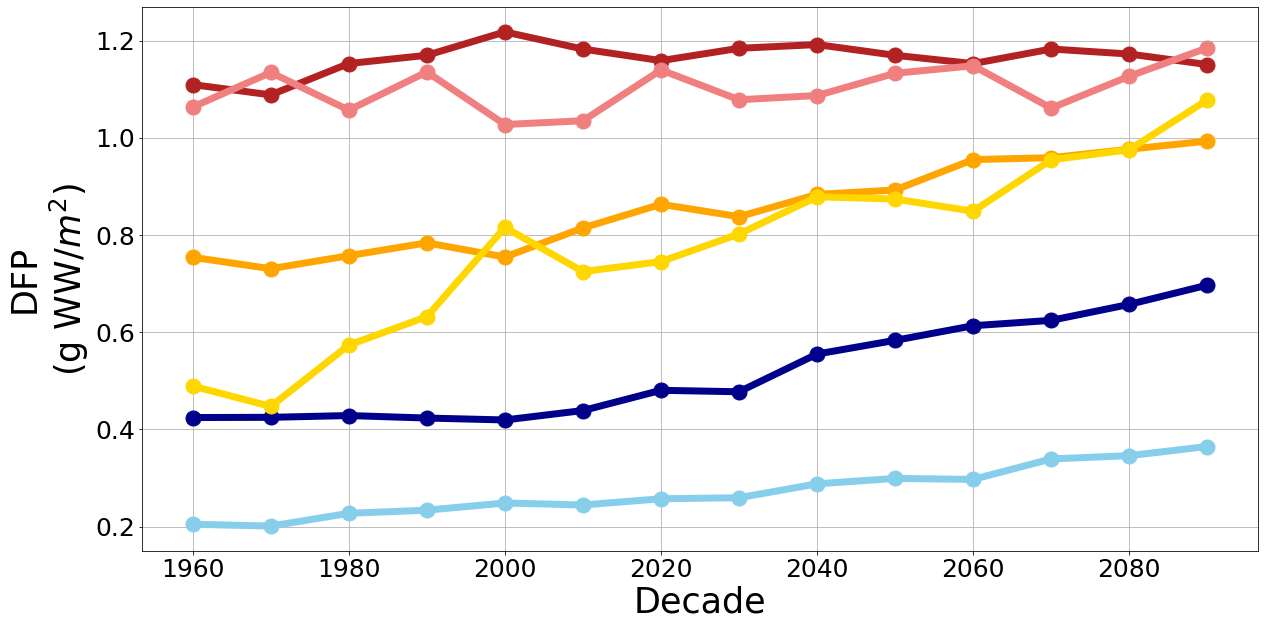

In [26]:
# create figure
fig = plt.figure(figsize=(20,10))

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(1,1,1)
# plot the regions of interest
ax.plot(decades_plt,data_plt.sel(region='Peninsula'),label="Peninsula",color='darkblue',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Weddell'),label="Weddell",color='skyblue',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Prydz'),label="Prydz",color='orange',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='DUrville'),label="D'Urville",color='gold',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Ross'),label="Ross",color='firebrick',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Amundsen'),label="Amundsen",color='lightcoral',linestyle='-',linewidth=7,marker='o',markersize=15)

# final plot tweaks    
plt.xlabel('Decade',fontsize=35)
plt.xticks(fontsize=25)
plt.ylabel(label,fontsize=35)
plt.yticks(fontsize=25)
#plt.legend(loc='lower left', ncol=1,fontsize=20);
plt.grid()

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)